In [ ]:
from google.colab import drive 
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd '/gdrive/Shareddrives/2021청년인재_고려대과정_10조/BiConvLSTM_Violence_Detection_Spatiotemporal_Encoder'

/gdrive/Shareddrives/2021청년인재_고려대과정_10조/BiConvLSTM_Violence_Detection_Spatiotemporal_Encoder


In [ ]:
import os
import random
import shutil
import time
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
filepath = '/gdrive/Shareddrives/2021청년인재_고려대과정_10조/BiConvLSTM_Violence_Detection_Spatiotemporal_Encoder/model_best.E_bi_max_pool_FiDetect_fold_0.tar'

In [ ]:
from networks.encoder import ConvEncoder
from networks.classification import Classification
import torch.nn as nn

from networks.BiConvLSTM import BiConvLSTM

class VP(nn.Module):
    def __init__(self, num_classes=2):
        super(VP, self).__init__()
        self.convenc = ConvEncoder()
        self.biconvlstm = BiConvLSTM(input_size=(14, 14), input_dim=512, hidden_dim=512, kernel_size=(3, 3), num_layers=1)
        self.classification = Classification(in_size=(14, 14), in_channels=512, num_classes=num_classes)

    def forward(self, clips):
        clips_feature_maps = self.convenc(clips)

        clips_feature_maps = self.biconvlstm(clips_feature_maps)

        # Max pool :)
        classification = self.classification(clips_feature_maps.max(dim=1)[0])
        return {'classification': classification}

In [ ]:
device = torch.device("cuda") 
model = VP()

RuntimeError: ignored

In [ ]:
checkpoint = torch.load(filepath)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
model

VP(
  (convenc): ConvEncoder(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [ ]:
vid_path = '/gdrive/Shareddrives/2021청년인재_고려대과정_10조/Data/UCF-Crime/UCF-Crime_Dataset'

In [ ]:
import glob
nofi = glob.glob(vid_path+'**/**nofi_**.mp4',recursive=True)

In [ ]:
nofi[0]

'/gdrive/Shareddrives/2021청년인재_고려대과정_10조/Data/UCF-Crime/UCF-Crime_Dataset/Abuse001_nofi_1.mp4'

In [ ]:
def read_video(filename):
    frames = []
    cap = cv2.VideoCapture(filename)
    while(cap.isOpened()):
        ret, frame = cap.read()
        frames.append(frame)
        if cap.get(cv2.CAP_PROP_POS_FRAMES) == cap.get(cv2.CAP_PROP_FRAME_COUNT):
            # If the number of captured frames is equal to the total number of frames, we stop
            break
    cap.release()
    video = np.stack(frames)
    return video

In [ ]:
fi = '/gdrive/Shareddrives/2021청년인재_고려대과정_10조/Data/UCF-Crime/UCF-Crime_Dataset/Abuse001_1.mp4'
nofi = '/gdrive/Shareddrives/2021청년인재_고려대과정_10조/Data/UCF-Crime/UCF-Crime_Dataset/Abuse001_nofi_1.mp4'

In [ ]:
video = read_video(nofi)

In [ ]:
import numpy as np
import cv2
import torch

class SelectFrames():
    def __init__(self, num_frames=20):

        self.num_frames = num_frames

    def __call__(self,clip):
        
        frame_count = clip.shape[0]
        step_size = frame_count // self.num_frames
        print(frame_count,self.num_frames, step_size)
        clip = clip[:self.num_frames*step_size,:,:,:]
        clip = clip[::step_size,:,:,:]
        return clip


class FrameDifference():
    def __init__(self, dim=0):

        self.dim = dim

    def __call__(self, clip):

        clip = clip.astype(np.float32)
        clip = np.diff(clip, axis=self.dim)
        return clip


class Downsample():
    def __init__(self, sampling_rate):

        self.sampling_rate = sampling_rate

    def __call__(self, clip):

        return clip[::self.sampling_rate, :, :, :]


class TileVideo():
    def __init__(self, num_frames):

        self.num_frames = num_frames

    def __call__(self, clip):

        num_tile = self.num_frames // clip.shape[0] + 1
        clip = np.tile(clip, (num_tile, 1, 1, 1))
        clip = clip[:self.num_frames, :, :, :]
        return clip


class RandomCrop():
    def __init__(self, size):

        self.size = size

    def __vid_crop(self, height, width):
        rand = np.random.random_integers(0, 4)
        if rand == 0:
            # center
            start_height = height // 2 - self.size // 2
            end_height = height // 2 + self.size // 2
            start_width = width // 2 - self.size // 2
            end_width = width // 2 + self.size // 2
        elif rand == 1:
            start_height = 0
            end_height = self.size
            start_width = 0
            end_width = self.size
        elif rand == 2:
            start_height = 0
            end_height = self.size
            start_width = width - self.size
            end_width = width
        elif rand == 3:
            start_height = height - self.size
            end_height = height
            start_width = 0
            end_width = self.size
        elif rand == 4:
            start_height = height - self.size
            end_height = height
            start_width = width - self.size
            end_width = width

        return start_height, end_height, start_width, end_width

    def __call__(self, clip):

        _, height, width, _ = clip.shape

        if height < self.size and width < self.size:
            return clip
        else:
            start_height, end_height, start_width, end_width = self.__vid_crop(height, width)

        clip = clip[:, start_height:end_height, start_width:end_width, :]

        return clip


class Resize():
    def __init__(self, size):

        self.size = size

    def __call__(self, clip):

        return np.array([cv2.resize(img, (self.size, self.size)) for img in clip])


class RandomHorizontalFlip():
    def __call__(self, clip):

        flip = np.random.choice([-1, 1])
        clip = clip[:, :, ::flip, :]
        return clip


class Normalize():
    def __call__(self, clip):

        return clip / 255.0


class ToTensor(object):
    def __call__(self, clip):

        return torch.from_numpy(clip.transpose(0, 3, 1, 2)).type(torch.FloatTensor)


In [ ]:
from data.data_reader import DatasetReader
from data.data_splitter import DatasetSplit
from data.data_transformer import DatasetTransform
from data.transforms import SelectFrames, FrameDifference, Downsample, TileVideo, RandomCrop, Resize, RandomHorizontalFlip, Normalize, ToTensor

val_dataset = DatasetReader(root_dir='gdrive/Shareddrives/2021청년인재_고려대과정_10조/Data/UCF-Crime/UCF-Crime_Dataset', data_name='FiDetect')
val_transformations = transforms.Compose([Resize(size=224), SelectFrames(num_frames=20), FrameDifference(dim=0), Normalize(), ToTensor()])
val_dataset = DatasetTransform(val_dataset, val_transformations)
val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=2, shuffle=False,
        num_workers=4, pin_memory=True)

model.eval()

end = time.time()
#for i, (input, target) in enumerate(val_loader):
input, target = val_loader
input_var = torch.autograd.Variable(input, volatile=True)
target_var = torch.autograd.Variable(target, volatile=True)
if not args.cpu:
    input_var = input_var.cuda()
    target_var = target_var.cuda()

# compute output
output_dict = model(input_var)

# measure accuracy and record loss
print('target : ',target)
print('output : ',output_dict['classification'])
precision = accuracy(output_dict['classification'], target)
prec.update(precision, input.size(0))

# measure elapsed time
batch_time.update(time.time() - end)
end = time.time()


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


ValueError: ignored

In [8]:
import matplotlib.pyplot as plt
accuracy = [30,40,50,30,60,56,30]
loss = [23,63,46,86,43,23,45]
prec = [1,4,43,63,2,3,45]

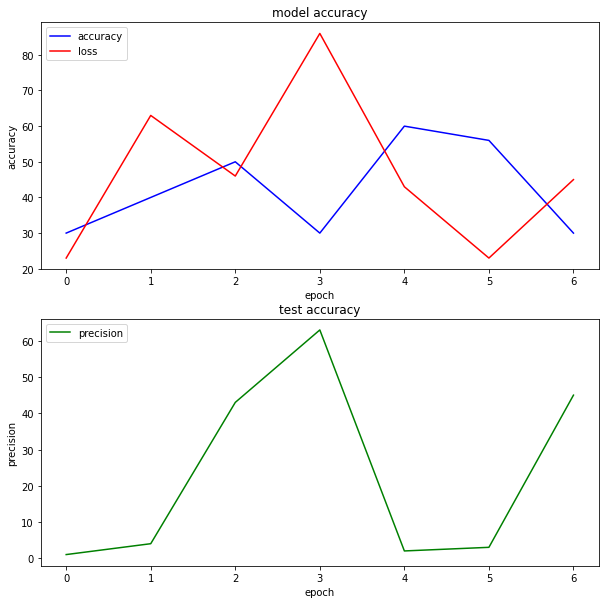

In [32]:

plt.figure(figsize=(10,10))

plt.subplot(2,1,1)
plt.title('model accuracy')
plt.plot(accuracy, color='b', label='accuracy')
plt.plot(loss, color='r', label='loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(prec, color='g', label='precision')
plt.title('test accuracy')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['precision'], loc='upper left')


plt.show()

In [ ]:


# summarize history for loss
plt.plot(prec)
plt.title('test accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['precision'], loc='upper left')